<a href="https://colab.research.google.com/github/leejielong/dcgan/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Convolutional Generative Adversarial Networks (DCGAN)

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Dropout, Flatten
import matplotlib.pyplot as plt
import os
import time
import numpy as np

In [24]:
# download mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32')
x_train = (x_train - 127.5) / 127.5 #normalise images to [-1,1]

In [25]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28) (10000,)


In [26]:
BATCH_SIZE = 256
BUFFER_SIZE = x_train.shape[0] #shuffle based on full train set
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create Models

We need to create 2 models, a generator and a discriminator

In [27]:
class Generator (tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.d1 = Dense(7*7*256, use_bias=False, input_shape=(100,))
        self.bn1 = BatchNormalization()
        self.act1 = LeakyReLU()

        self.rs2 = Reshape((7,7,256))
        self.deconv2 = Conv2DTranspose(128,(5,5),strides=(1,1), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.act2 = LeakyReLU()

        self.deconv3 = Conv2DTranspose(64,(5,5),strides=(2,2), padding='same', use_bias=False)
        self.bn3 = BatchNormalization()
        self.act3 = LeakyReLU()      

        self.deconv4 = Conv2DTranspose(1,(5,5),strides=(2,2), padding='same', use_bias=False, activation='tanh')

    def call(self, x, training=None):
        x = self.d1(x)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        x = self.rs2(x)
        x = self.deconv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)

        x = self.deconv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)

        x = self.deconv4(x)
        return x

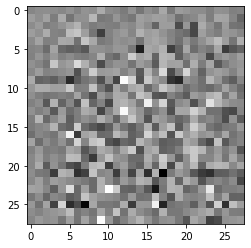

In [28]:
generator = Generator()

noise = tf.random.normal([1,100])
generated_image = generator(noise)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [29]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])
        self.act1 = LeakyReLU()
        self.drop1 = Dropout(0.3)

        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.act2 = LeakyReLU()
        self.drop2 = Dropout(0.3) 

        self.flat3 = Flatten()
        self.d3 = Dense(1)

    def call (self, x, training=None):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.drop1(x, training=training)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.drop2(x, training=training)

        x = self.flat3(x)
        x = self.d3(x)

        return x


In [30]:
discriminator = Discriminator()
classification = discriminator(generated_image)
print(classification)

tf.Tensor([[0.00065321]], shape=(1, 1), dtype=float32)


### Define Generator and Discriminator loss functions

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints

In [32]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

### Training Loop

In [33]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
print(seed)

tf.Tensor(
[[ 0.8547265  -0.54826075  1.1274014  ...  0.13029645  1.0536461
  -0.41689467]
 [-1.4940894  -0.93123424  0.41612113 ... -0.97404355  0.31795114
   0.6752795 ]
 [-0.25058815  0.16369605  0.22034174 ... -0.52577996 -0.20049943
   2.6165214 ]
 ...
 [-0.41759688  0.45304644 -1.1365162  ...  0.1958379  -1.5089253
  -1.0153425 ]
 [ 0.9950754  -0.8568344  -0.05825172 ...  0.4998529   0.3910834
   0.3951717 ]
 [-0.01165855  1.0303466   0.5305835  ...  0.36884096  0.5236215
  -0.93729347]], shape=(16, 100), dtype=float32)


In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) #get noise samples

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss, real_loss, fake_loss = discriminator_loss(real_output,fake_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_loss, fake_loss

In [36]:
def train(dataset, epochs):

    history = {
        'gen_loss' : [],
        'disc_loss' : [],
        'real_loss' : [],
        'fake_loss' : []
    }

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss, real_loss, fake_loss = train_step(image_batch)
        
        history['gen_loss'].append(gen_loss)
        history['disc_loss'].append(disc_loss)
        history['real_loss'].append(real_loss)
        history['fake_loss'].append(fake_loss)

        generate_and_save_images(generator, epoch+1, seed) #use the same seed to generate images, showing how the model is learning over epochs

        # #save model every 15 epochs
        # if (epoch+1) % 15 ==0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)
        
        print(f'Epoch: {epoch+1:03} | Time Taken: {time.time()-start}s')

    # last generate after final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    return history

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4)) #print 16 examples

    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray') #tanh produces -1 to +1 outputs, so need to rescale and shift to 0-255
        plt.axis('off') #dont show axes

    plt.savefig(f'image_at_epoch_{epoch:04d}')
    plt.show()


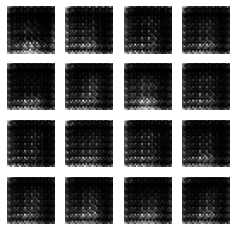

Epoch: 001 | Time Taken: 17.011422395706177s


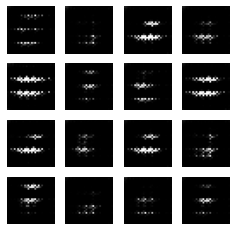

Epoch: 002 | Time Taken: 14.969573020935059s


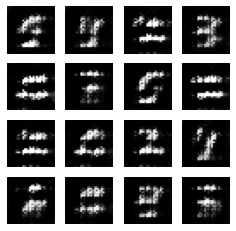

Epoch: 003 | Time Taken: 14.32592511177063s


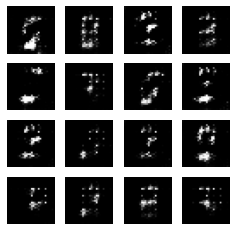

Epoch: 004 | Time Taken: 14.1677565574646s


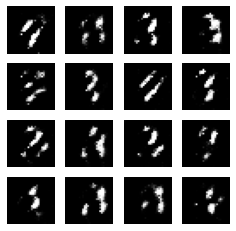

Epoch: 005 | Time Taken: 13.895048141479492s


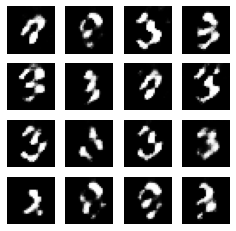

Epoch: 006 | Time Taken: 13.99056601524353s


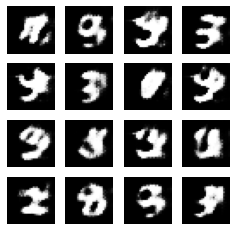

Epoch: 007 | Time Taken: 14.284437894821167s


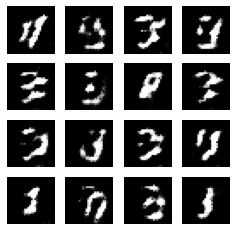

Epoch: 008 | Time Taken: 14.201666116714478s


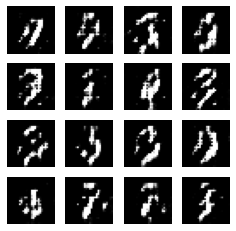

Epoch: 009 | Time Taken: 14.138526916503906s


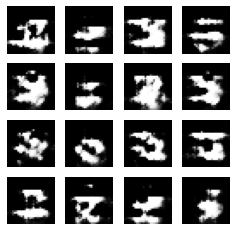

Epoch: 010 | Time Taken: 14.280295610427856s


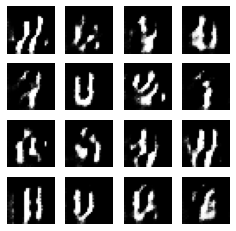

Epoch: 011 | Time Taken: 14.049220323562622s


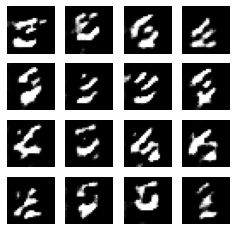

Epoch: 012 | Time Taken: 14.028470039367676s


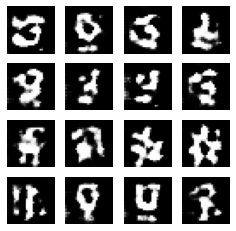

Epoch: 013 | Time Taken: 14.230985164642334s


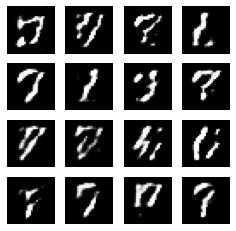

Epoch: 014 | Time Taken: 14.10835576057434s


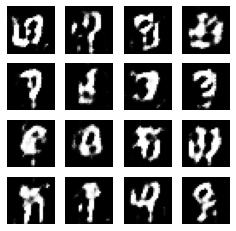

Epoch: 015 | Time Taken: 14.173943042755127s


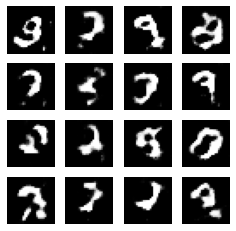

Epoch: 016 | Time Taken: 14.323590755462646s


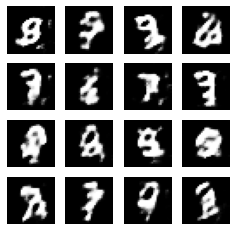

Epoch: 017 | Time Taken: 14.119994163513184s


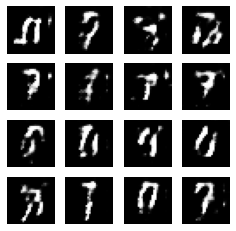

Epoch: 018 | Time Taken: 14.103800535202026s


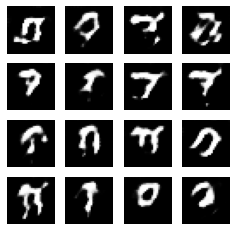

Epoch: 019 | Time Taken: 14.308218002319336s


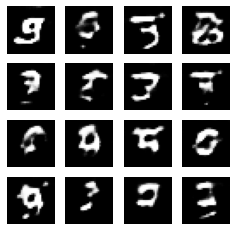

Epoch: 020 | Time Taken: 14.151317358016968s


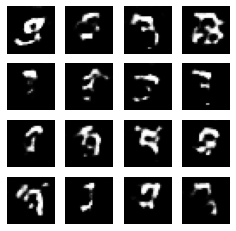

Epoch: 021 | Time Taken: 14.145557641983032s


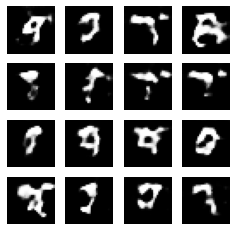

Epoch: 022 | Time Taken: 14.302992820739746s


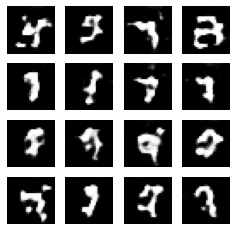

Epoch: 023 | Time Taken: 14.14371371269226s


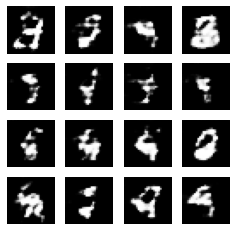

Epoch: 024 | Time Taken: 14.136137247085571s


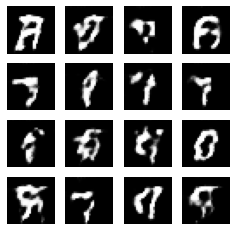

Epoch: 025 | Time Taken: 14.265456676483154s


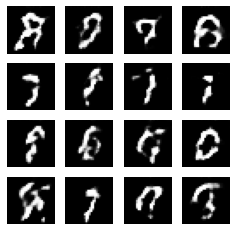

Epoch: 026 | Time Taken: 14.113808393478394s


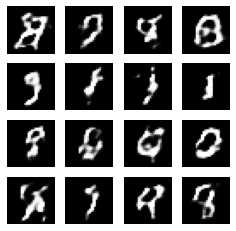

Epoch: 027 | Time Taken: 14.13646912574768s


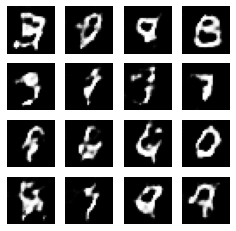

Epoch: 028 | Time Taken: 14.325048208236694s


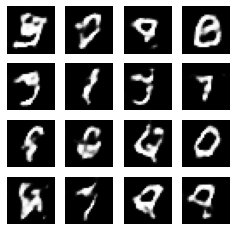

Epoch: 029 | Time Taken: 14.143169164657593s


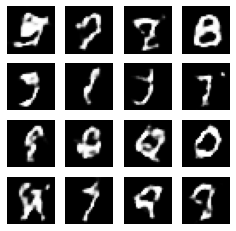

Epoch: 030 | Time Taken: 14.139395475387573s


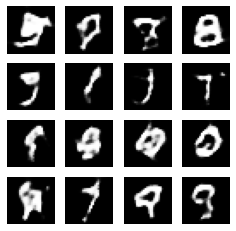

Epoch: 031 | Time Taken: 14.31928539276123s


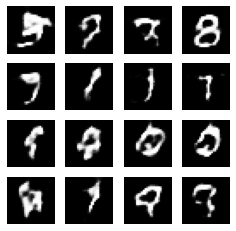

Epoch: 032 | Time Taken: 14.161198854446411s


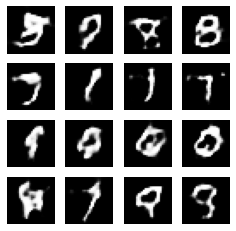

Epoch: 033 | Time Taken: 14.160387754440308s


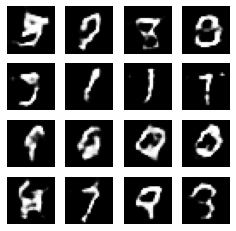

Epoch: 034 | Time Taken: 14.290490627288818s


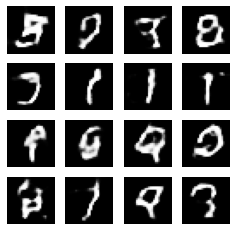

Epoch: 035 | Time Taken: 14.109891176223755s


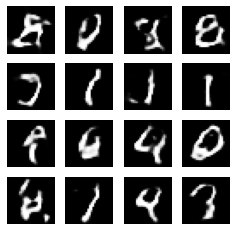

Epoch: 036 | Time Taken: 14.139925956726074s


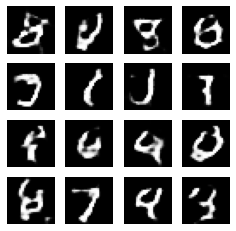

Epoch: 037 | Time Taken: 14.32029914855957s


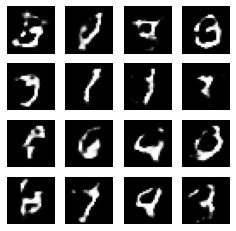

Epoch: 038 | Time Taken: 14.151509284973145s


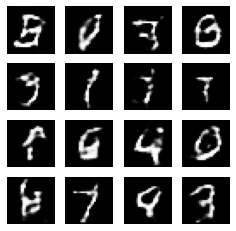

Epoch: 039 | Time Taken: 14.134279489517212s


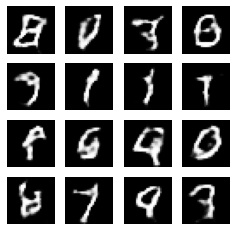

Epoch: 040 | Time Taken: 14.291233539581299s


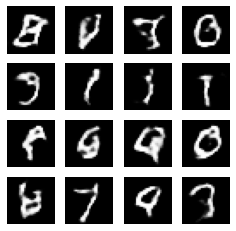

Epoch: 041 | Time Taken: 14.129966974258423s


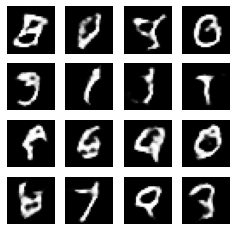

Epoch: 042 | Time Taken: 14.15598440170288s


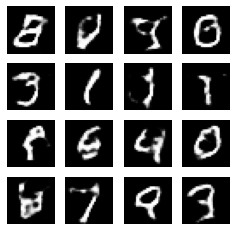

Epoch: 043 | Time Taken: 14.299601078033447s


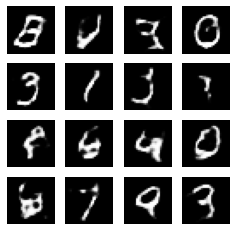

Epoch: 044 | Time Taken: 14.150247573852539s


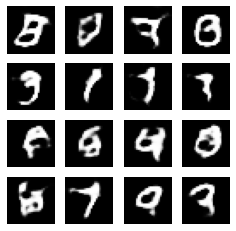

Epoch: 045 | Time Taken: 14.127498865127563s


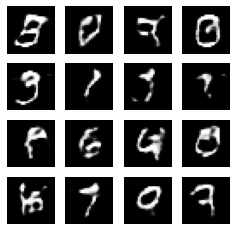

Epoch: 046 | Time Taken: 14.317738771438599s


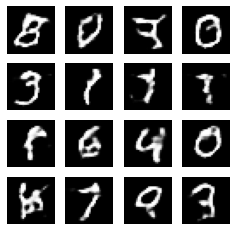

Epoch: 047 | Time Taken: 14.147915601730347s


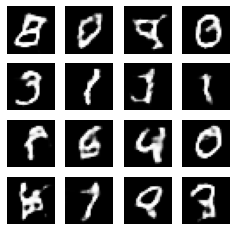

Epoch: 048 | Time Taken: 14.170188188552856s


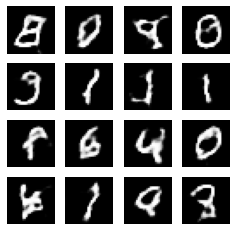

Epoch: 049 | Time Taken: 14.339761972427368s


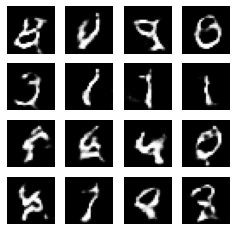

Epoch: 050 | Time Taken: 14.151296377182007s


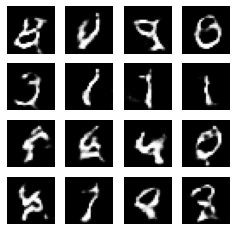

In [37]:
history = train(train_dataset,EPOCHS)

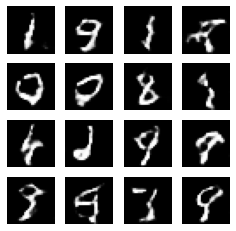

In [42]:
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator,0,noise)

In [39]:
print(generator.summary())

Model: "generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  1254400   
_________________________________________________________________
batch_normalization (BatchNo multiple                  50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  819200    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    multiple                  

In [40]:
print(discriminator.summary())

Model: "discriminator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple              

In [46]:
gen_loss = list(map(lambda x: x.numpy(), history['gen_loss']))
disc_loss = list(map(lambda x: x.numpy(), history['disc_loss']))
real_loss = list(map(lambda x: x.numpy(), history['real_loss']))
fake_loss = list(map(lambda x: x.numpy(), history['fake_loss']))

print(gen_loss)
print(disc_loss)
print(real_loss)
print(fake_loss)

[0.570278, 0.8670501, 0.8609364, 0.94765675, 0.8402158, 0.88590026, 0.94913435, 0.8993277, 0.87129444, 0.8807853, 0.9660392, 0.9932212, 1.1686354, 0.85212296, 0.91625863, 0.895255, 1.25602, 1.2584106, 1.1403809, 1.2209477, 1.2233782, 1.3914796, 1.3414354, 1.5417095, 1.292253, 1.277786, 1.1864291, 1.3525764, 1.1179571, 1.0641627, 1.1947427, 1.0150659, 0.90928733, 0.9626362, 0.9389137, 0.93708867, 1.001285, 1.0720026, 1.1018736, 0.99199903, 0.893456, 0.9341464, 0.88226867, 1.0964596, 0.8837132, 1.0277522, 0.886266, 0.93809956, 0.88217515, 0.9107158]
[1.7202716, 1.2296629, 1.165791, 1.2791414, 1.2306092, 1.1668916, 1.1496625, 1.200098, 1.2255716, 1.3249096, 0.9943198, 1.2654427, 0.87873703, 1.1551639, 1.2800558, 1.1522787, 0.8710943, 0.91608334, 1.0973685, 1.0802009, 0.9945737, 1.0338323, 1.1649175, 0.8191351, 0.901446, 0.93856704, 1.1235023, 1.1059866, 1.1379472, 1.1834562, 1.0245235, 1.1029186, 1.221958, 1.329504, 1.1081612, 1.1739101, 1.1191574, 1.3466115, 1.061121, 1.2157753, 1.261639

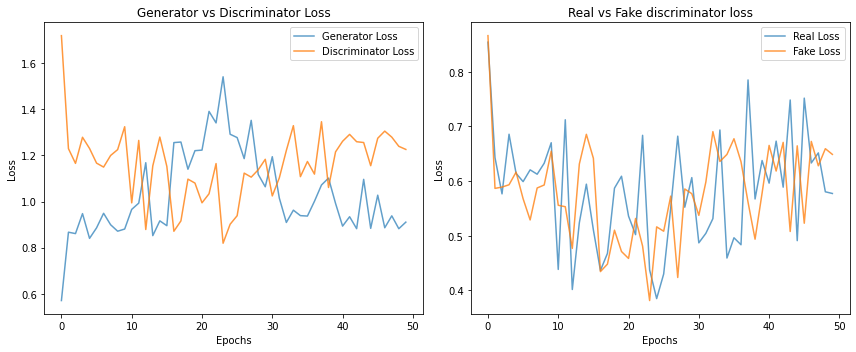

In [48]:
### Plot train and validation curves
epochs = range(len(gen_loss))

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Generator vs Discriminator Loss')
plt.plot(epochs, gen_loss, alpha=0.7, label='Generator Loss')
plt.plot(epochs, disc_loss, alpha=0.8, label='Discriminator Loss')
# plt.ylim(0.3,100)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.title('Real vs Fake discriminator loss')
plt.plot(epochs, real_loss,alpha=0.7,label='Real Loss')
plt.plot(epochs, fake_loss,alpha=0.78,label='Fake Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()